# Example showcasing IO tasks

Notebook showing a workflow examples for downloading and saving EO imaging data

In [21]:
%load_ext autoreload
%autoreload 2
%autosave 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosave disabled


In [22]:
from eolearn.core.eoworkflow import LinearWorkflow, Dependency
from eolearn.core.eodata import FeatureType

In [23]:
from sentinelhub import BBox, CRS

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
from eolearn.core import SaveToDisk, LoadFromDisk
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature, DEMWCSInput, S2L2AWCSInput, L8L1CWCSInput

Define ROI BBOX and time interval

In [26]:
roi_bbox = BBox(bbox=[5.60, 52.68, 5.75, 52.63], crs=CRS.WGS84)
time_interval = ('2018-04-01', '2018-05-01')
ID = 'ce55231e-6f5c-4910-84a4-2768a2c585f1'

### Request different types of layers and data sources to an eopatch

In this workflow example, the input task requests S2 L1C bands at 20m resolution, and other eotasks add `NDVI` features, digital elevation model `DEM`, S2 L2A bands.

In [36]:
layer = 'BANDS-S2-L1C'

input_task = S2L1CWCSInput(layer=layer, 
                           resx='20m', resy='20m', 
                           maxcc=.8, time_difference=datetime.timedelta(hours=2),
                          instance_id=ID)

add_ndvi = S2L1CWCSInput(layer='NDVI', instance_id=ID)

add_dem = DEMWCSInput(layer='DEM', instance_id=ID)

add_l2a = S2L2AWCSInput(layer='BANDS-S2-L2A', instance_id=ID)

add_sen2cor = AddSen2CorClassificationFeature('SCL', layer='BANDS-S2-L2A', instance_id=ID)

save = SaveToDisk('io_example', overwrite_permission=2, compress_level=1)

Run workflow

In [37]:
workflow = LinearWorkflow(input_task, add_ndvi, add_l2a, add_sen2cor, add_dem, save)

In [38]:
result = workflow.execute({input_task: {'bbox': roi_bbox, 'time_interval': time_interval},
                           save: {'eopatch_folder': 'eopatch'}})

In [8]:
workflow.execute?

Check contents of eopatch

In [5]:
eopatch = result[save]
eopatch

NameError: name 'result' is not defined

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(8, 278, 506, 13), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(8, 278, 506, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(8, 278, 506, 1), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(8, 278, 506, 1), dtype=uint8)
    SCL: numpy.ndarray(shape=(8, 278, 506, 1), dtype=int32)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(278, 506, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(0, 7200)
    time_interval: [datetime.datetime(2018, 4, 1, 0, 0), datetime.datetime(2018, 5, 1, 0, 0)]
  }
  bbox: BBox(((5.6, 52.63), (5.75, 52.68)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2018, 4, 3, 10, 41, 5), ..., datetime.datetime(2018, 4, 26, 10, 52, 2)], length=8
)

### Plot results

#### S2 L1C RGB bands

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch.data['BANDS-S2-L1C'][3][..., [3,2,1]] * 2.5, vmin=0, vmax=1);

NameError: name 'eopatch' is not defined

<Figure size 720x720 with 0 Axes>

#### NDVI dervied from S2 L1C bands

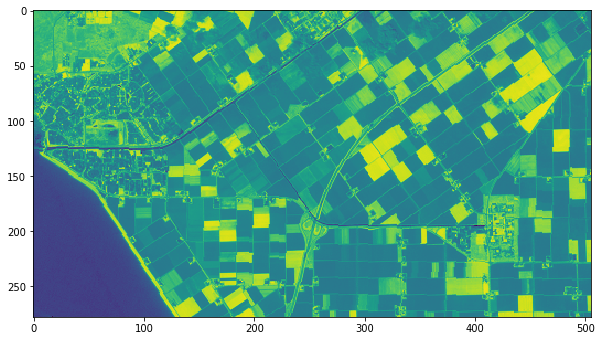

In [41]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch.data['NDVI'][3].squeeze());

#### S2 L2A RGB bands

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


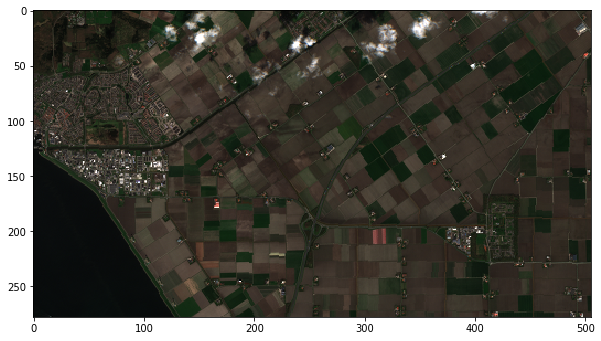

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch.data['BANDS-S2-L2A'][3][...,[3,2,1]] * 2.5, vmin=0, vmax=1);

#### Sen2cor scene classification mask

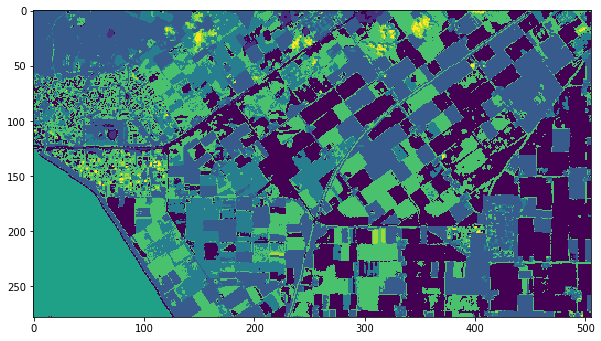

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch.mask['SCL'][3].squeeze());

#### Mapzen Digital Elevation Model

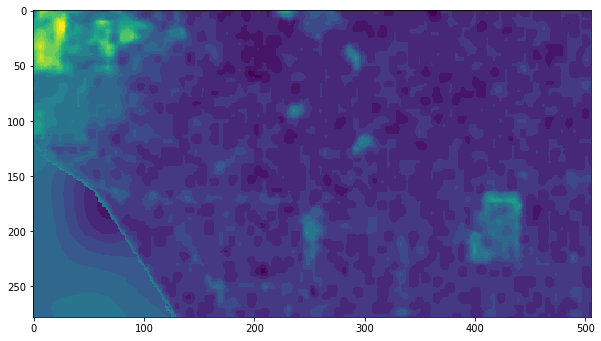

In [44]:
plt.figure(figsize=(10, 10))
plt.imshow(eopatch.data_timeless['DEM'].squeeze());

## Load in saved eopatch

In [45]:
load = LoadFromDisk('io_example')

In [46]:
new_eopatch = load.execute(eopatch_folder='eopatch')